In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install SpeechRecognition


In [6]:
import os
import pandas as pd
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

from pydub.effects import normalize
from scipy.io import wavfile
import noisereduce as nr

import warnings
import multiprocessing as mp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [335]:
path = '/content/drive/MyDrive/AudioFiles/RAVDESS/Actor_03/03-01-07-02-02-01-03.wav'

In [337]:
rawsound = AudioSegment.from_file(path)
rawsound

In [338]:
# Function to preprocess audio file
def preprocess_audio_file(path):
    # Step 1: Load the audio file into an 'AudioSegment' object, and extract the sample rate.
    rawsound = AudioSegment.from_file(path)
    sr, x = wavfile.read(path)

    # Step 2: Normalize to +5.0 dBFS, Transform audio signals to an array.
    normalizedsound = normalize(rawsound, headroom=5.0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

    # Step 3: Trim silence in the beginning and end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    print("Length after trimming:", len(xt))  # Debugging: Print length after trimming

    if len(xt) == 0:
        print("Warning: Trimmed audio length is zero.")
        return None, sr

    # Step 4: Right-side padding for length equalization.
    max_length = 173056  # maximum lengthed audio
    padded_x = np.pad(xt, (0, max_length - len(xt)), 'constant')

    # Step 5: Reduce noise
    final_x = nr.reduce_noise(y=padded_x, sr=sr)

    return final_x, sr

In [339]:
final_x, sr = preprocess_audio_file(path)

Length after trimming: 146944


In [340]:
final_x

array([ 4.748184 , -3.496517 ,  4.4931545, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

In [341]:
sr

48000

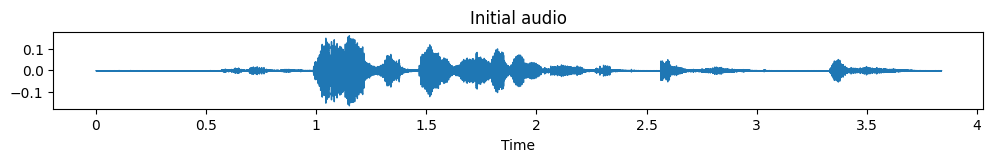

In [342]:
#Load the audio file into an 'AudioSegment' object, and extract the sample rate.

final_x, sr = librosa.load(path, sr = sr)
rawsound = AudioSegment.from_file(path)
plt.figure(figsize=(12,1))
librosa.display.waveshow(final_x, sr = sr)
plt.title('Initial audio')
rawsound

In [343]:

# Function to extract MFCC features
# Capture the spectral characteristics of the audio signal
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr)
    return np.ravel(mfcc_result) if flatten else mfcc_result

# Function to calculate Spectral Centroid
# Indicates the "center of mass" of the spectrum, providing information about the brightness of the sound
def spectral_centroid(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid_result = librosa.feature.spectral_centroid(y=data, sr=sr)
    return np.ravel(spectral_centroid_result)

# Function to calculate Spectral Contrast
# Captures the difference in amplitude between peaks and valleys in the spectrum.
def spectral_contrast(data, sr, frame_length=2048, hop_length=512):
    spectral_contrast_result = librosa.feature.spectral_contrast(y=data, sr=sr)
    return np.ravel(spectral_contrast_result)

# Function to extract various audio features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = []

    # MFCC feature extraction
    mfcc_features = mfcc(data, sr, frame_length, hop_length)
    if mfcc_features.size > 0:
        result.append(mfcc_features)

    # Spectral Centroid feature extraction
    spectral_centroid_features = spectral_centroid(data, sr, frame_length, hop_length)
    if spectral_centroid_features.size > 0:
        result.append(spectral_centroid_features)

    # Spectral Contrast feature extraction
    spectral_contrast_features = spectral_contrast(data, sr, frame_length, hop_length)
    if spectral_contrast_features.size > 0:
        result.append(spectral_contrast_features)

    # Concatenate feature vectors
    if len(result) > 0:
        return np.hstack(result)
    else:
        return np.array([])


In [344]:

# Function to pitch-shift the audio
def pitch(data, sr, n_steps=2.0):
    pitched_audio = librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)
    return pitched_audio

# Function to add additive white Gaussian noise to the audio (AWGN)
def noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(data))
    return data + noise

# Function to get features from the audio file
def get_features(path, duration=2.5, offset=0.6, noise_level=0.005):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)

    # Original audio
    noised_audio = noise(data, noise_level=noise_level)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))  # Add features of noised audio to the result

    # Pitch-shifted audio
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))  # Add features of pitch-shifted audio to the result

    # Pitch-shifted and noised audio
    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1, noise_level=noise_level)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))  # Add features of pitch-shifted and noised audio to the result

    return audio


In [345]:
audio_ = get_features(path)

In [346]:
audio_

array([[-537.32421875, -493.50546265, -486.20901489, ...,   44.52490581,
          32.22974606,   19.71834127],
       [-343.06682143, -299.40564402, -296.83446164, ...,   13.94798687,
          13.74275629,   13.18499593],
       [-533.65484619, -498.99359131, -507.45852661, ...,   43.66170281,
          36.22764424,   22.55676551],
       [-334.33280815, -300.43701156, -304.88283156, ...,   12.41271584,
          13.57093417,   14.19340475]])

In [347]:
audio_.shape

(4, 3024)

In [348]:
import timeit
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
# from tqdm import tqdm
start = timeit.default_timer()

def process_feature(path):
    features = get_features(path)
    X = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    return X


In [349]:
X_ = process_feature(path)

In [350]:
X_[0].shape

(3024,)

In [351]:
X_

[array([-537.32421875, -493.50546265, -486.20901489, ...,   44.52490581,
          32.22974606,   19.71834127]),
 array([-341.39118127, -295.63918809, -293.7867065 , ...,   13.25184301,
          12.62862075,   13.5951711 ]),
 array([-533.65484619, -498.99359131, -507.45852661, ...,   43.66170281,
          36.22764424,   22.55676551]),
 array([-341.57215563, -299.77390653, -300.22248966, ...,   14.14715819,
          14.77107561,   13.36562077])]

In [352]:
# standardizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_)

In [353]:
X_train

array([[-1.01882219, -0.97206695, -0.89091623, ...,  1.02797043,
         0.79560333,  0.60861838],
       [ 1.0008431 ,  1.02051976,  1.02903542, ..., -1.02902652,
        -1.09112692, -0.93812586],
       [-0.98099853, -1.02733444, -1.10293965, ...,  0.97119294,
         1.1804259 ,  1.32561892],
       [ 0.99897763,  0.97888162,  0.96482045, ..., -0.97013684,
        -0.88490231, -0.99611145]])

In [354]:
# Load the model from the file
import joblib


svm_model_loaded = joblib.load('/content/drive/MyDrive/svm_model.pkl')


In [355]:
y_pred = svm_model_loaded.predict(X_train)

In [356]:
y_pred

array([1, 2, 3, 2])

In [357]:
X_train_cnn = np.expand_dims(X_train, axis = 2)

In [358]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/audio_cnn_lstm_model_new.h5')


In [359]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 3024, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3024, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1512, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1512, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1512, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 756, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 756, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 756, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 378, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 378, 32)             │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 378, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 189, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 189, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12096)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,548,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,0

 Total params: 1,647,913 (6.29 MB)

 Trainable params: 1,646,951 (6.28 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

In [360]:
# Make a prediction
prediction = model.predict(X_train_cnn)

# Output the prediction
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
[[3.0551109e-05 8.5325018e-03 9.9520774e-05 2.1301159e-03 5.4637417e-03
  7.0242117e-05 9.8367333e-01]
 [1.3703289e-03 9.1987737e-03 1.3208516e-01 1.8595984e-04 7.9323500e-01
  2.8804498e-04 6.3636743e-02]
 [1.5969377e-04 1.0493257e-04 5.1705609e-04 1.4320995e-01 1.8980944e-01
  6.2666917e-03 6.5993220e-01]
 [3.9032484e-06 9.8583210e-01 5.1708096e-03 9.7377617e-09 9.6153060e-05
  2.0345169e-07 8.8968482e-03]]


In [361]:
predicted_classes = np.argmax(prediction, axis=1)


In [362]:
predicted_classes

array([6, 4, 6, 1])

In [363]:
predicted_classes += 1


In [364]:
print(predicted_classes)  # Output: array([7, 7, 4, 7])


[7 5 7 2]


In [365]:
emotion = {
    '03' : 'happy',
    '01' : 'neutral',
    '02' : 'calm',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}

In [366]:
predicted_emotions = [emotion[f'{pred:02}'] for pred in predicted_classes]

# Print the mapped emotions
print(predicted_emotions)

['disgust', 'angry', 'disgust', 'calm']
